In [142]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from statsmodels.stats.proportion import proportion_confint

plt.style.use('seaborn')

In [2]:
df = pd.read_csv('credit_card_default_analysis.csv')

## 1.

Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [17]:
limit_bal_def0 = df[df['default'] == 0]['LIMIT_BAL']
limit_bal_def1 = df[df['default'] == 1]['LIMIT_BAL']

In [448]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

*1.а) Равенство медианных значений кредитного лимита*

In [521]:
def compare_stats_plot(data1, data2, plot1_titile='LIMIT_BAL distribution', 
                                     plot2_title='LIMIT_BAL medians compare'):
    # medians dist
    plt.figure(dpi=100, figsize=(10, 3))
    plt.title(plot1_titile)
    sns.distplot(data1, label='def0', color='mediumblue', hist_kws={'alpha': 0.25}, kde_kws={'alpha': 0.25})
    plt.axvline(data1.median(), label='def0 median', linestyle='--', color='mediumblue')
    sns.distplot(data2, label='def1', color='mediumseagreen', hist_kws={'alpha': 0.25}, kde_kws={'alpha': 0.25})
    plt.axvline(data2.median(), label='def1 median', linestyle='--', color='mediumseagreen')
    plt.legend()
    plt.xlabel(None)
    plt.yticks([])
    plt.show()

    data_to_plot = [data1, data2]

    fig = plt.figure(1, dpi=100)
    ax = fig.add_subplot(111)
    bp = ax.boxplot(data_to_plot, patch_artist=True)

    for box in bp['boxes']:
        box.set( color='#7570b3', linewidth=2)
        box.set( facecolor = '#1b9e77' )

    for whisker in bp['whiskers']:
        whisker.set(color='#7570b3', linewidth=2)

    for cap in bp['caps']:
        cap.set(color='#7570b3', linewidth=2)

    for median in bp['medians']:
        median.set(color='#b2df8a', linewidth=2)

    for flier in bp['fliers']:
        flier.set(marker='o', color='#e7298a', alpha=0.5)

    ax.set_xticklabels(['def0', 'def1'])
    plt.title(plot2_title)
    plt.show()

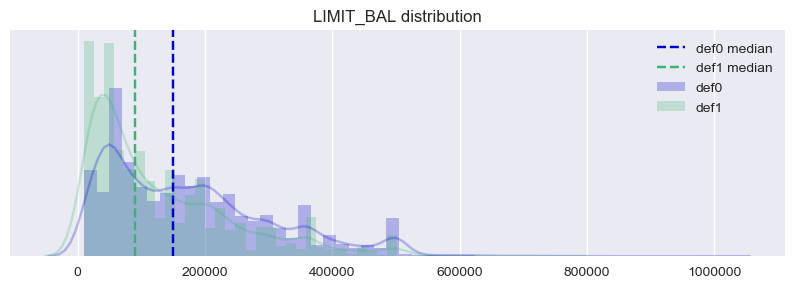

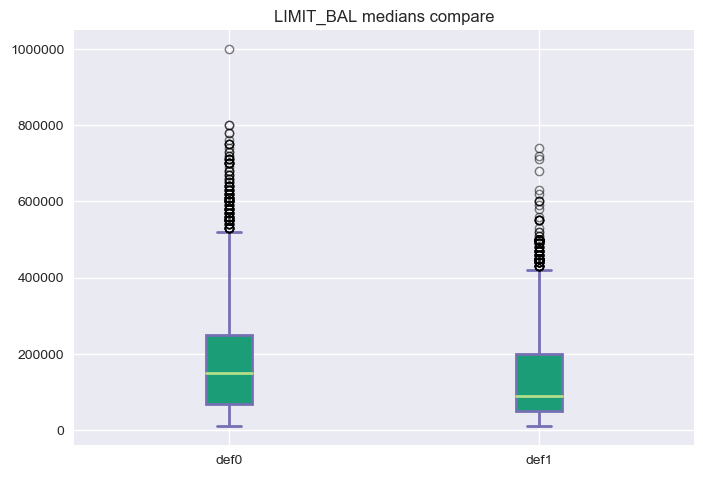

In [523]:
compare_stats_plot(limit_bal_def0, limit_bal_def1)

In [507]:
# Интервальная оценка медианы

limit_bal_def0_median_scores = list(map(np.median, get_bootstrap_samples(limit_bal_def0.values, 1000)))
limit_bal_def1_median_scores = list(map(np.median, get_bootstrap_samples(limit_bal_def1.values, 1000)))
print("95% confidence interval for the def0 median repair time:",  stat_intervals(limit_bal_def0_median_scores, 0.05))
print("95% confidence interval for the def1 median repair time:",  stat_intervals(limit_bal_def1_median_scores, 0.05))

95% confidence interval for the def0 median repair time: [150000. 150000.]
95% confidence interval for the def1 median repair time: [80000. 90000.]


Точечная оценка разности медиан

In [508]:
# Точечная оценка разности медиан

print("\ndifference between medians:", np.median(limit_bal_def0) - np.median(limit_bal_def1))


difference between medians: 60000.0


In [516]:
# Интервальная оценка разности медиан

delta_median_scores = list(map(lambda x: x[0] - x[1], zip(limit_bal_def0_median_scores, limit_bal_def1_median_scores)))
print("95% confidence interval for the difference between medians:",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians: [60000. 70000.]


*1.b) Равенство распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних*

$H_0$: среднее значение кредитного лимита одинаково для вернувших и не вернувших кредит <br>
$H_1$: среднее значение отличается в этих двух группах.

In [24]:
# критерий Манна — Уитни
stats.mannwhitneyu(limit_bal_def0, limit_bal_def1)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

*Значимы ли полученные результаты с практической точки зрения?*

Медианы уверенно различаются на уровне значимости 0.05, с разницой суммы при точечной оценке = 60000. Можно сказать, что полученные результаты значимы.

## 2. 

Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

In [135]:
# man = 1, woman = 0 (no sexism! just data science)
sex_def0 = df[df['default'] == 0]['SEX'].map({2: 0, 1: 1})
sex_def1 = df[df['default'] == 1]['SEX'].map({2: 0, 1: 1})

In [156]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1 * n1 + p2 * n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1 / n1 + 1 / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [169]:
conf_interval_sex_def0 = proportion_confint(sum(sex_def0), len(sex_def0), method = 'wilson')
conf_interval_sex_def1 = proportion_confint(sum(sex_def1), len(sex_def1), method = 'wilson')

print(f'95% interval for def0 {np.round(conf_interval_sex_def0, 3)}')
print(f'95% interval for def1 {np.round(conf_interval_sex_def1, 3)}')

print(f'95% confidence interval for difference shapes: {np.round(proportions_confint_diff_ind(sex_def0, sex_def1), 3)}')

print(f'p-value: {proportions_diff_z_test(proportions_diff_z_stat_ind(sex_def0, sex_def1))}')

95% interval for def0 [0.38  0.392]
95% interval for def1 [0.421 0.445]
95% confidence interval for difference shapes: [-0.061 -0.034]
p-value: 4.472866521609831e-12


Очевидно смещение разницы долей на интервальной оценке, и данное смещение статзначимо

## 3.

Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

In [170]:
edu_def0 = df[df['default'] == 0]['EDUCATION']
edu_def1 = df[df['default'] == 1]['EDUCATION']

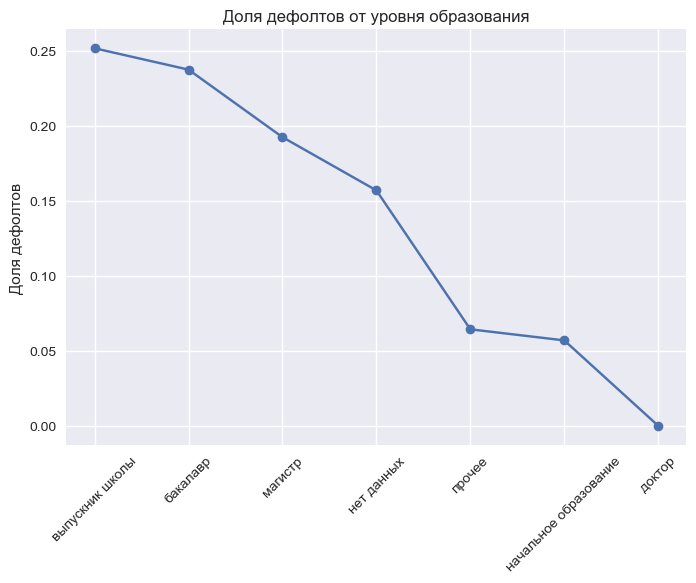

In [367]:
decode_edu = {0: 'доктор', 
              1: 'магистр',
              2: 'бакалавр',
              3: 'выпускник школы',
              4: 'начальное образование',
              5: 'прочее',
              6: 'нет данных'}

df_edustat = pd.DataFrame({'decode': list(decode_edu.values()),
                           'shape': df['EDUCATION'].value_counts(normalize=True)[list(decode_edu.keys())],
                           'DR_true': df.groupby('EDUCATION').mean()['default'][list(decode_edu.keys())]})

df_edustat.sort_values('DR_true', ascending=False, inplace=True)
plt.figure(dpi=100)
plt.title('Доля дефолтов от уровня образования')
plt.plot(df_edustat['decode'], df_edustat['DR_true'], marker='o', label='True')
plt.xticks(rotation=45)
plt.ylabel('Доля дефолтов')
plt.show()

## 4.

Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [411]:
mar_pivot = df.pivot_table(index='default', values="LIMIT_BAL", columns='MARRIAGE', aggfunc = len, fill_value=0)
mar_pivot

MARRIAGE,0,1,2,3
default,,,,
0,49,10453,12623,239
1,5,3206,3341,84


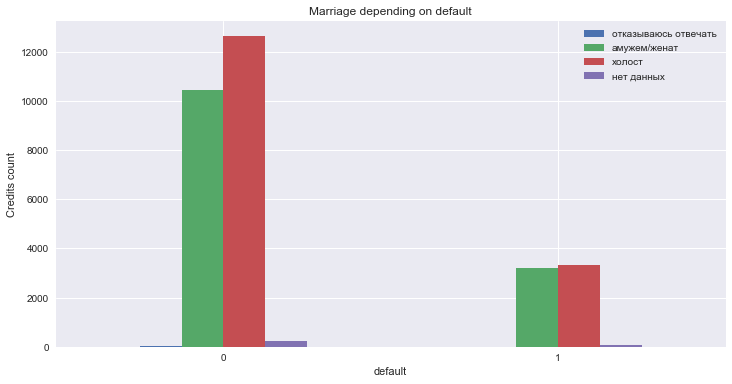

In [437]:
mar_names = ["отказываюсь отвечать", "амужем/женат", "холост", "нет данных"]
mar_pivot.plot.bar(figsize=(12, 6), rot=0)
plt.xlabel("default")
plt.ylabel("Credits count")
plt.title("Marriage depending on default")
plt.legend(mar_names)
plt.grid(True)
plt.show()

In [443]:
# применимость критерия хи-квадрат
print('Кол-во измерений в совокупной выборке:', np.sum(np.array(mar_pivot)))
print('Доля элементов меньше 5:', np.sum(np.array(mar_pivot) < 5) / (mar_pivot.shape[0] * mar_pivot.shape[1]))

# коэффициент V Крамера
chi2, p, dof, exp = stats.chi2_contingency(mar_pivot)
n = mar_pivot.sum(axis = 0).sum()
cr_v = (chi2 / n) ** 0.5

print('Cramer\'s V = %.4f' % cr_v)
print('p-value = ', p)

Кол-во измерений в совокупной выборке: 30000
Доля элементов меньше 5: 0.0
Cramer's V = 0.0345
p-value =  8.825862457577375e-08


## 5.

Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [177]:
age_def0 = df[df['default'] == 0]['AGE']
age_def1 = df[df['default'] == 1]['AGE']

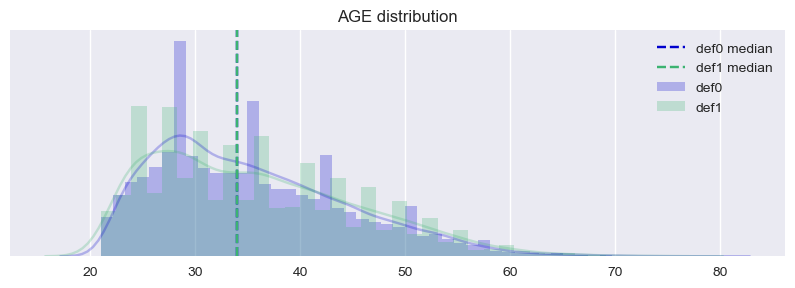

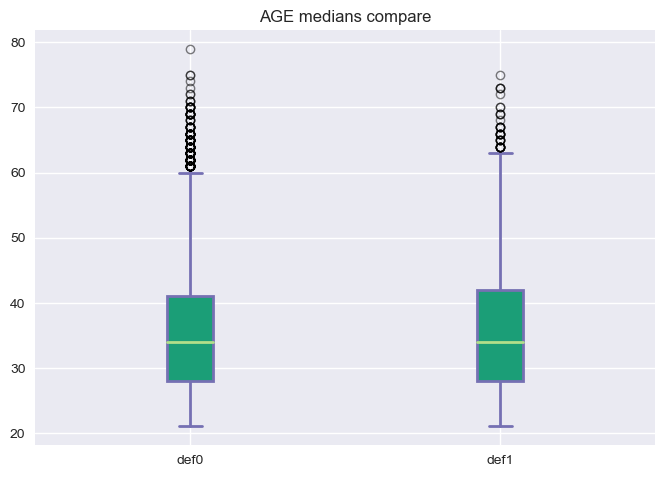

In [525]:
compare_stats_plot(age_def0, age_def1, 'AGE distribution', 'AGE medians compare')

In [526]:
np.random.seed(123)

age_def0_scores = np.median(get_bootstrap_samples(age_def0.values, 1000), axis=1)
age_def1_scores = np.median(get_bootstrap_samples(age_def1.values, 1000), axis=1)

print("95% confidence interval def0 clients:",  stat_intervals(age_def0_scores))
print("95% confidence interval def1 clients:",  stat_intervals(age_def1_scores))

stats.mannwhitneyu(age_def0, age_def1)

95% confidence interval def0 clients: [34. 34.]
95% confidence interval def1 clients: [34. 35.]


MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

Полученные результаты не значимы с практической точки зрения